In [8]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import glob
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd


In [9]:
# PATHS 
ROOT_DATA_DIR = r"C:\Users\LENOVO\OneDrive\Desktop\Project"
MODEL_PATH = os.path.join(ROOT_DATA_DIR, "best_efficientnet_b4.pth")
TEST_DIR = os.path.join(ROOT_DATA_DIR, "CLASSIFICATION_ROIS_128x128")   # Using ROI folder for evaluation

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
TARGET_SIZE = (128, 128)
BATCH_SIZE = 32

print("Running on device:", DEVICE)


Running on device: cpu


In [10]:
test_transform = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
print(" Test transforms defined")


 Test transforms defined


In [11]:
class PCBTestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_paths = glob.glob(os.path.join(img_dir, "*", "*.png"))
        self.labels = [os.path.basename(os.path.dirname(p)) for p in self.img_paths]
        self.transform = transform
        self.classes = sorted(list(set(self.labels)))
        self.label_map = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        path = self.img_paths[idx]
        image = Image.open(path).convert("RGB")
        label_str = self.labels[idx]
        label = self.label_map[label_str]
        if self.transform:
            image = self.transform(image)
        return image, label, os.path.basename(path)


In [12]:
test_dataset = PCBTestDataset(TEST_DIR, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Loaded test dataset: {len(test_dataset)} images")
print("Classes:", test_dataset.classes)


Loaded test dataset: 3057 images
Classes: ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']


In [13]:
test_dataset = PCBTestDataset(TEST_DIR, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Loaded test dataset: {len(test_dataset)} images")
print("Classes:", test_dataset.classes)


Trained model loaded successfully


In [15]:
all_preds = []
all_labels = []
all_image_names = []

with torch.no_grad():
    for imgs, labels, names in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_image_names.extend(names)

accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f" Test Accuracy: {accuracy * 100:.2f}%")


 Test Accuracy: 96.57%



Classification Report 
                 precision    recall  f1-score   support

   Missing_hole       1.00      0.99      1.00       497
     Mouse_bite       0.98      0.95      0.96       502
   Open_circuit       0.97      0.97      0.97       511
          Short       0.95      0.97      0.96       523
           Spur       0.91      0.97      0.94       501
Spurious_copper       0.99      0.94      0.96       523

       accuracy                           0.97      3057
      macro avg       0.97      0.97      0.97      3057
   weighted avg       0.97      0.97      0.97      3057



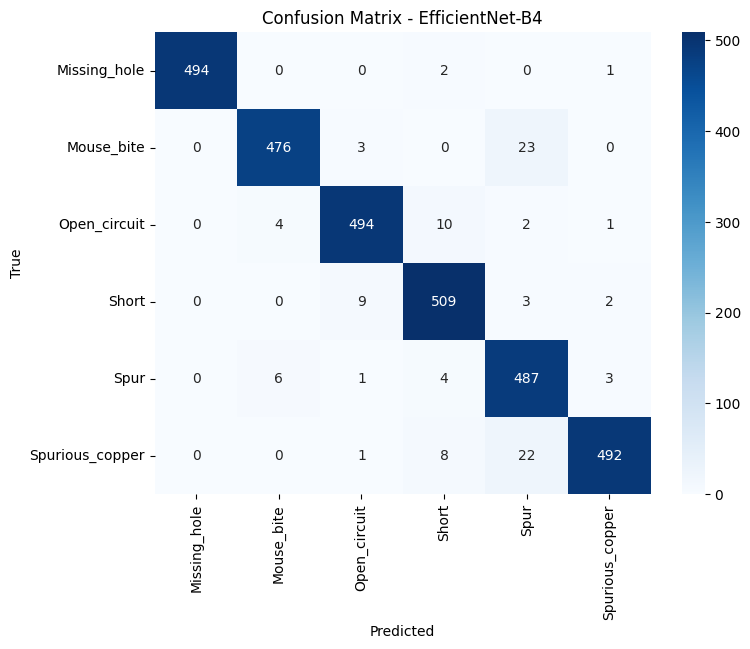

In [16]:
print("\nClassification Report ")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - EfficientNet-B4")
plt.show()


In [11]:
# SAVE ANNOTATED PREDICTIONS 
import matplotlib.pyplot as plt
import numpy as np
import os


ANNOTATED_SAVE_DIR = os.path.join(ROOT_DATA_DIR, "ANNOTATED_TEST_RESULTS_VISUALIZED")
os.makedirs(ANNOTATED_SAVE_DIR, exist_ok=True)


def unnormalize(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    return np.clip(img, 0, 1)


plt.switch_backend('Agg')  # ensures saving works even without display

model.eval()
saved_classes = set()

for imgs, labels, names in test_loader:
    imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
    outputs = model(imgs)
    _, preds = torch.max(outputs, 1)

    for i in range(len(imgs)):
        true_label = test_dataset.classes[labels[i].cpu()]
        pred_label = test_dataset.classes[preds[i].cpu()]

        # Save one annotated example per category
        if true_label not in saved_classes:
            img = unnormalize(imgs[i].cpu())
            plt.imshow(img)
            plt.title(f"True: {true_label} | Pred: {pred_label}")
            plt.axis("off")

            save_path = os.path.join(
                ANNOTATED_SAVE_DIR,
                f"{true_label}_pred_{pred_label}.png"
            )

            plt.savefig(save_path, bbox_inches='tight')
            plt.close()

            saved_classes.add(true_label)
            print(f"✅ Saved annotated example for class: {true_label}")
            print(f"🖼️ Image saved at: {save_path}")

        # Stop when all classes are saved
        if len(saved_classes) == len(test_dataset.classes):
            break

    if len(saved_classes) == len(test_dataset.classes):
        break

print(f"\nAnnotated predictions saved for all {len(saved_classes)} classes in:")
print(f"   {ANNOTATED_SAVE_DIR}")



Annotated predictions saved for all 0 classes in:
   C:\Users\LENOVO\OneDrive\Desktop\Project\ANNOTATED_TEST_RESULTS_VISUALIZED
